# AC Power Flow Analysis

In [1]:
from jupyterquiz import display_quiz

module_no = "04"
lesson_slug = "ac-power-flow"

quiz_json = lesson_slug + ".json"
git_quiz = f"https://raw.githubusercontent.com/PowerCyberTraining/powercybertraining.github.io/refs/heads/cui/pct/modules/{module_no}/questions/{quiz_json}"
local_quiz = f"questions/{quiz_json}"

color_dict = {
    '--jq-multiple-choice-bg': '#CC0000',      # Wolfpack Red - for multiple choice background
    '--jq-mc-button-bg': '#FFFFFF',            # Wolfpack White - for button background
    '--jq-mc-button-border': '#E1E1E1',        # Light gray - for button borders
    '--jq-mc-button-inset-shadow': '#000000',  # Wolfpack Black - for button shadows
    '--jq-many-choice-bg': '#D14905',          # Pyroman Flame - for many choice background
    '--jq-numeric-bg': '#427E93',              # Carmichael Aqua - for numeric background
    '--jq-numeric-input-bg': '#FFFFFF',        # Wolfpack White - for input background
    '--jq-numeric-input-label': '#000000',     # Wolfpack Black - for input label
    '--jq-numeric-input-shadow': '#767676',    # Gray - for input shadow
    '--jq-incorrect-color': '#990000',         # Reynolds Red - for incorrect answers
    '--jq-correct-color': '#4F868E',           # Genomic Green - for correct answers
    '--jq-text-color': '#FFFFFF'               # Wolfpack White - for question text
}

| Information | Details |
|----------|---------|
| Lead Author | Hantao Cui |
| Learning Objectives | • Understand power flow equations and their mathematical formulation<br>• Implement power flow calculations using numerical methods<br>• Analyze Jacobian matrices for power flow problems<br>• Scale implementations from small to large power systems<br>• Visualize power flow results on network diagrams |
| Prerequisites | • Basic knowledge of power systems<br>• Python programming skills<br>• Familiarity with NumPy and SciPy |
| Estimated Time | 90 minutes |
| Topics | Power flow equations, Newton-Raphson method, Numerical Jacobian calculation, Admittance matrix, Network visualization, Computational efficiency |


## Conceptual Overview

A typical nonlinear equation is the power flow equations. Power flow equations are algebraic equations enforcing the power balancing at each bus. Intuitively, the equations require that, at each bus, the power injection (generation minus load) is equal to the power that leaves the bus through connected lines. 

Using the complex power definition, the power flow equations are as simple as:

$$
\begin{bmatrix}
P_1 + j Q_1 \
P_2 + j Q_2 \
\vdots \
P_N + j Q_N
\end{bmatrix} = 
\text{diag}(V) (I)^*
=
\text{diag}(V) (Y V)^*
$$
where $P_i$ and $Q_i$ are the real and reactive power injection at bus $i$, $V_i$ and $V_j$ are the voltage at bus $i$ and $j$, $Y$ is the admittance matrix, and

$$
\text{diag}(V) = 
\begin{bmatrix}
V_1 & 0 & 0 & \cdots & 0 \\
0 & V_2 & 0 & \cdots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \cdots & V_N
\end{bmatrix}
$$




If bus `k` has no injection, the corresponding $P_k$ and $Q_k$ are zero.



For a system with $N$ buses, there are $2N$ real-valued equations. There has to be $2N$ unkonwns to solve the equations. 

As we have learned from power system analysis, there are three types of buses, PQ, PV and Slack. The unknowns are:


| Bus Type | Knowns | Unknowns |
| -------- | -------- | -------- |
| PQ | $P_i, Q_i$ | $V_i, \theta_i$ |
| PV | $P_i, V_i$ | $Q_i, \theta_i$ |
| Slack | $V_i, \theta_i$ | $P_i, Q_i$ |



## Worked Example: 3-Bus Power System

We consider a three-bus system from {cite:p}`crow2016computational` (Example 3.11). I have taken the liberty to use a 0-based index to align with Python code.

It is a three bus sytem with the following bus parameters:

| Bus | Type | V | Pgen | Qgen | Pload | Qload |
| ---- | -------- | -------- | -------- | -------- | -------- | -------- |
| 0 | Slack | 1.02 | -- | -- | 0.0 | 0.0 |
| 1 | PV | 1.00 | 0.5 | -- | 0.0 | 0.0 |
| 2 | PQ | -- | 0 | 0 | 1.2 | 0.5 |

And the line parameters are given as

| From | To | R | X | B |
| ---- | -------- | -------- | -------- | -------- |
| 0 | 1 | 0.02 | 0.3 | 0.15 |
| 0 | 2 | 0.01 | 0.1 | 0.1 |
| 1 | 2 | 0.01 | 0.1 | 0.1 |



First, let's make the admittance matrix.


In [2]:
import numpy as np
from scipy.optimize import fsolve

Y = np.zeros((3, 3), dtype=np.complex128)

# Diagonal elements
Y[0, 0] = 1 / (0.02 + 0.3j) + 1 / (0.01 + 0.1j) + 1j * 0.15 / 2 + 1j * 0.1 / 2
Y[1, 1] = 1 / (0.02 + 0.3j) + 1 / (0.01 + 0.1j) + 1j * 0.15 / 2 + 1j * 0.1 / 2
Y[2, 2] = 1 / (0.01 + 0.1j) + 1 / (0.01 + 0.1j) + 1j * 0.1 / 2 + 1j * 0.1 / 2

# Off-diagonal elements
Y[0, 1] -= 1 / (0.02 + 0.3j)
Y[1, 0] -= 1 / (0.02 + 0.3j)

Y[0, 2] -= 1 / (0.01 + 0.1j)
Y[2, 0] -= 1 / (0.01 + 0.1j)

Y[1, 2] -= 1 / (0.01 + 0.1j)
Y[2, 1] -= 1 / (0.01 + 0.1j)

print(Y)

[[ 1.21133795-13.09457417j -0.22123894 +3.31858407j
  -0.99009901 +9.9009901j ]
 [-0.22123894 +3.31858407j  1.21133795-13.09457417j
  -0.99009901 +9.9009901j ]
 [-0.99009901 +9.9009901j  -0.99009901 +9.9009901j
   1.98019802-19.7019802j ]]


We can verify that the result matches the textbook:

In [3]:
# print Y in a polar form (using degrees)
print("Y magnitudes:")
print(np.abs(Y))

print("Y angles:")
print(np.angle(Y, deg=True))

Y magnitudes:
[[13.15048335  3.32595053  9.9503719 ]
 [ 3.32595053 13.15048335  9.9503719 ]
 [ 9.9503719   9.9503719  19.80124259]]
Y angles:
[[-84.71478916  93.81407483  95.71059314]
 [ 93.81407483 -84.71478916  95.71059314]
 [ 95.71059314  95.71059314 -84.26061502]]


We can move on and write the power flow equations. To conform with the standard form of `f(x) = 0`, the power injections are subtracted from both sides.

In [4]:
def pf_3bus(x):

    # we can make the unknowns to be
    #   x = [P0, Q0, theta1, Q1, theta2, V2]
    #   where theta is in radians and V is in per unit

    V = np.array([1.02, 1.00, x[5]])
    theta = np.array([0.0, x[2], x[4]])
    Vc = V * np.exp(1j * theta)

    # calculate the power injection into the network
    #   note that power leaves the bus into the network
    S = np.diag(Vc) @ np.conj(Y @ Vc)

    # power leaving each bus via the lines
    #   minus power injection at each bus shall equal to 0
    P = np.real(S) - np.array([x[0], 0.5, -1.2])
    Q = np.imag(S) - np.array([x[1], x[3], -0.5])

    return np.concatenate([P, Q])


initial_guess = [0, 0, 0, 0, 0, 1.0]
sol, infodict, ier, mesg = fsolve(pf_3bus, initial_guess, full_output=True)

print(sol)

[ 0.70867913  0.28056964 -0.01009172 -0.04462179 -0.06351473  0.98158465]


This result is exactly the same as the results from the textbook.

### Key Formulation Notes

If you have some impressions from a Power System Analysis course, you
may remember the lengthy derivations of the power flow equations and its
Jacobian matrix. In fact, this formulation comes much simpler than the textbook
ones, so it can be interesting to understand why both formulations work.

:::{admonition} Exercise

You may also have many questions about the formulation, such as

1. Why are the P&Q at a slack bus and the Q at a PV bus included as variables,
  resulting in six variables for three buses?

2. Following up on the previous question, why do we include two equations at the
  slack bus and one reactive power equation at the PV bus?

3.  Why are the variables not ordered in the typical way, namely, unknown phase
  angles and then unknown voltage magnitudes, yet it solves?

4. Following up on the previous question, why is that ordering the convention (as
  written in textbooks and implemented in many programs)? Is that still relevant?


Please work on these exercise questions.

:::


:::{admonition} Hints
:class: tip

1. They are dependent variables and can be either included in the full problem (to
be solved simultaneously), or removed from the problem but evaluated when other
unknowns are found.

2. The number of variables must equal the number of (independent) equations.

3. Variables and equations can be in arbitrary order.

4. Grouping variables and equations will help create structural patterns in the Jacobian matrix.

:::

## Calculating Jacobian Numerically

In [5]:
def numerical_jacobian(func, x, eps=1e-6):
    """Calculate the Jacobian matrix using finite differences."""
    n = len(x)
    f0 = func(x)
    m = len(f0)
    J = np.zeros((m, n))

    for j in range(n):
        # Create a copy of x with a small perturbation in the j-th element
        x_perturbed = x.copy()
        x_perturbed[j] += eps

        # Calculate the perturbed function values
        f1 = func(x_perturbed)

        # Compute the j-th column of the Jacobian
        J[:, j] = (f1 - f0) / eps

    return J

In [6]:
# Example: Calculate the Jacobian for our 3-bus power flow problem
x = np.array(
    [0.70867913, 0.28056964, -0.01009172, -0.04462179, -0.06351473, 0.98158465]
)
J = numerical_jacobian(pf_3bus, x)

np.set_printoptions(precision=4)

print("Numerical Jacobian matrix (shape):", J.shape)
print(J)

Numerical Jacobian matrix (shape): (6, 6)
[[ -1.       0.      -3.3871   0.      -9.956   -0.3669]
 [  0.       0.      13.1392   0.      -9.7567  -0.46  ]
 [  0.       0.      -9.6529   0.      19.483    0.7212]
 [  0.      -1.       0.1915   0.       0.3601 -10.1427]
 [  0.       0.      -0.7113  -1.       0.4515  -9.9397]
 [  0.       0.       1.4894   0.      -3.1079  18.8298]]


## Applying to Large Test Systems

The implementation above is elegant due to the very few lines of code. However,
without providing the Jacobian matrix, computational speed challenges are
expected.

We will use the ANDES software to load the IEEE 300-bus system.

The code below downloads the data from the MATPOWER repository, stores it in a temporary file, and loads it using ANDES.

In [7]:
import os
import tempfile
import urllib.request

# Test case name -- change it for testing
case_name = "case300.m"

def download_to_temp(case_name):
    """
    Download a MATPOWER case to a local temp file.
    """

    base_url = "https://raw.githubusercontent.com/MATPOWER/matpower/refs/heads/master/data/"
    url = base_url + case_name

    # Create a temporary file
    with tempfile.NamedTemporaryFile(delete=False, suffix=".m") as temp_file:
        # Download the file
        urllib.request.urlretrieve(url, temp_file.name)

        print(f"File downloaded and saved to {temp_file.name}")

        # Verify if the file exists
        if os.path.exists(temp_file.name):
            print(f"File size: {os.path.getsize(temp_file.name)} bytes")
        else:
            print("Download failed")

    return temp_file


temp_file = download_to_temp(case_name)

File downloaded and saved to /tmp/tmpxsbgymrt.m
File size: 65678 bytes


In [8]:
import andes
from kvxopt import matrix

ss = andes.load(temp_file.name, no_output=True)

The code below builds the admittance matrix and obtains the indices needed to reuse the power residual equations from the above.

In [9]:
Y = matrix(ss.Line.build_y())


class NodalData:

    def __init__(self, ss):
        nbus = ss.Bus.n

        self.P = np.zeros(nbus)
        self.Q = np.zeros(nbus)
        self.V = np.ones(nbus)
        self.theta = np.zeros(nbus)

    def set_zero(self):
        self.P[:] = 0
        self.Q[:] = 0
        self.V[:] = 0
        self.theta[:] = 0


ndata = NodalData(ss)

The following boilerplate code takes care of the indexing machinery. It is needed due to the ANDES data structure, where PQ, Slack and PV generators are stored separately from Bus. 

In [10]:
class IndexLoc:
    def __init__(self, ss):
        self.pq = ss.Bus.idx2uid(ss.PQ.bus.v)
        self.pv = ss.Bus.idx2uid(ss.PV.bus.v)
        self.slack = ss.Bus.idx2uid(ss.Slack.bus.v)

        self.gen = np.concatenate([self.pv, self.slack])
        self.non_gen = np.setdiff1d(np.arange(ss.Bus.n), self.gen)
        self.non_slack = np.setdiff1d(np.arange(ss.Bus.n), self.slack)
        self.shunt = ss.Bus.idx2uid(ss.Shunt.bus.v)


loc = IndexLoc(ss)

Next, we will define the power mismatch equations.

In [11]:
def pf_large(x, ss, ndata, loc):

    P, Q, V, theta = ndata.P, ndata.Q, ndata.V, ndata.theta

    # Important: clear the injection vector at the beginning of iteration
    ndata.set_zero()

    # PQ
    np.subtract.at(P, loc.pq, ss.PQ.p0.v)
    np.subtract.at(Q, loc.pq, ss.PQ.q0.v)

    # PV
    V[loc.pv] = ss.PV.v0.v
    np.add.at(P, loc.pv, ss.PV.p0.v)

    # Slack
    theta[loc.slack] = ss.Slack.a0.v
    V[loc.slack] = ss.Slack.v0.v

    # retrieve unknowns from `x`
    # Unknowns in `x` are grouped by theta and then V
    #   Note that the `loc.non_gen` can have random order
    #   No sorting is needed, because x will be in the same order

    theta[loc.non_slack] = x[: len(loc.non_slack)]
    V[loc.non_gen] = x[len(loc.non_slack) :]

    # shunt elements
    np.add.at(P, loc.shunt, ss.Shunt.g.v * V[loc.shunt] ** 2)
    np.add.at(Q, loc.shunt, ss.Shunt.b.v * V[loc.shunt] ** 2)

    Vc = V * np.exp(1j * theta)
    S = np.diag(Vc) @ np.conj(Y @ Vc)

    # Power leaving each bus via the lines
    #   minus the amount of injection shall be equal to 0

    Pmis = np.real(S) - P
    Qmis = np.imag(S) - Q

    mis = np.concatenate([Pmis[loc.non_slack], Qmis[loc.non_gen]])

    return mis

Moving on, the initial guess is set to solve the problem as a flat start (ones for voltages and zeros for unknown phase angles). 

In [12]:
def get_initial_guess(ss, loc):
    return np.concatenate([ss.Bus.a0.v[loc.non_slack],
                                ss.Bus.v0.v[loc.non_gen]])

initial_guess = get_initial_guess(ss, loc)

sol, infodict, ier, mesg = fsolve(
    pf_large, initial_guess, args=(ss, ndata, loc), full_output=True
)

print(mesg)

The solution converged.


In [13]:
print(f"Voltage magnitude vector:\n{ndata.V}")
print(f"Voltage phase angle vector:\n{ndata.theta}")

Voltage magnitude vector:
[1.0284 1.0353 0.9971 1.0308 1.0191 1.0312 0.9934 1.0153 1.0034 1.0205
 1.0057 0.9974 0.9977 0.9992 1.0344 1.0316 1.0649 0.9819 1.001  0.9752
 0.9963 1.0501 1.0057 1.0234 0.9986 0.975  1.0248 1.0415 0.9757 1.0012
 1.0205 1.0205 1.0537 1.0219 1.0295 1.045  1.0009 1.0088 1.0217 1.0346
 0.9779 1.0021 1.0475 1.0255 0.9981 0.9962 1.0052 1.0152 1.0335 0.9918
 0.9789 1.0248 0.9907 1.016  0.9583 0.948  0.9627 0.9513 0.9794 0.9696
 0.9776 0.9965 0.9632 0.9838 0.99   0.982  0.9872 1.0342 1.025  0.9871
 0.9908 0.992  1.0153 1.0318 1.0274 1.052  1.052  0.9929 1.0182 1.
 0.9894 1.006  1.0007 1.0288 0.9957 1.0223 1.0095 0.99   0.9753 0.9732
 0.9745 0.9702 0.9768 0.9603 1.0249 0.9348 0.9299 1.0435 0.9584 0.9871
 0.9728 1.0006 1.0233 1.0103 0.9978 1.0001 1.0024 1.0028 1.0191 0.9861
 1.0046 1.002  1.0221 1.0193 1.0476 1.0471 1.055  1.0117 1.043  1.051
 1.0155 1.0435 1.0161 1.0081 1.0528 1.0528 1.0577 1.0735 0.9869 1.0048
 1.0535 1.0435 0.9664 1.0177 0.963  0.9845 0.9987 0.9866

It is worth mentioning that the solution above for the IEEE 300-bus system matches the ANDES and MATPOWER solution. We can see the code implementation is straightforward. By using SciPy's `fsolve` function, the power flow problem is formulated as a general root-finding problem and readily solved.

## Performance Remarks on the Numerical Jacobian

With this example, we also illustrate that solving large power flow cases without providing the Jacobian matrix is computationally inefficient. 

In [14]:
%timeit fsolve(pf_large, initial_guess, args=(ss, ndata, loc))

267 ms ± 84.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


It reports around 200 ms to solve the 300-bus power flow. The following reports the solution time using ANDES:

In [15]:
andes.config_logger()  # show logging output
ss.PFlow.run();

-> System connectivity check results:
  No islanded bus detected.
  System is interconnected.
  Each island has a slack bus correctly defined and enabled.

-> Power flow calculation
           Numba: Off
   Sparse solver: KLU
 Solution method: NR method
Power flow initialized in 0.0036 seconds.
0: |F(x)| = 10.51482497
1: |F(x)| = 2.585704245
2: |F(x)| = 0.3536420223
3: |F(x)| = 0.008448363916
4: |F(x)| = 4.64692361e-06
5: |F(x)| = 1.376843084e-12
Converged in 6 iterations in 0.0129 seconds.


The logging output shows that ANDES takes about 10 ms to solve the same case.

There are two main reasons:

- Divided difference requires 2*N evaluations of the residual function, where `N` is the number of rows (or columns) of the matrix
- The Jacobian matrix from the divided difference is formulated as a dense matrix.

The second reason needs more elaboration. Divided difference has no information about the sparsity pattern by just having a handle to the residual function, so the initial result must be stored as a dense matrix. The solver can choose to convert it to a sparse matrix or not, but such a conversion has memory cost and must be done for each step. For small to medium sized systems, the conversion overhead may outweight the gain.

## Sparsity Pattern in the Jacobian Matrix

The IEEE 300-bus system is large enough to demonstrate the sparsity of the Jacobian matrix. In our problem formulation, the unknown variables (theta and V) are grouped. The residual equations are also grouped by active and reactive power residuals. Therefore, the Jacobian matrix is expected in a block-structured form of:

$$J = \begin{bmatrix} \frac{\partial P}{\partial \theta} & \frac{\partial P}{\partial V} \\ \frac{\partial Q}{\partial \theta} & \frac{\partial Q}{\partial V} \end{bmatrix}$$


The Jacobian matrix will be visualized next. First, let's retrieve the Jacobian matrix from the last step of the iterations by `fsolve`:

In [16]:
fjac = infodict["fjac"]

# Apply threshold to remove small values
thres = 1e-3
fjac_thresholded = fjac.copy()
fjac_thresholded[np.abs(fjac_thresholded) < thres] = 0

:::{admonition} Note on the threshold

The threshold of 1e-3 is used to remove small values from the Jacobian matrix. These small values can come from rounding errors in divided differences or small values as a result of system parameters. The threshold value is somewhat arbitrary and should not be set too large.

:::

The following script plots the Jacobian matrix - the non-zero elements are in black, and the zeros are in white. The horizontal axis correspond to the variables, and the vertical axis correspond to the residual equations.

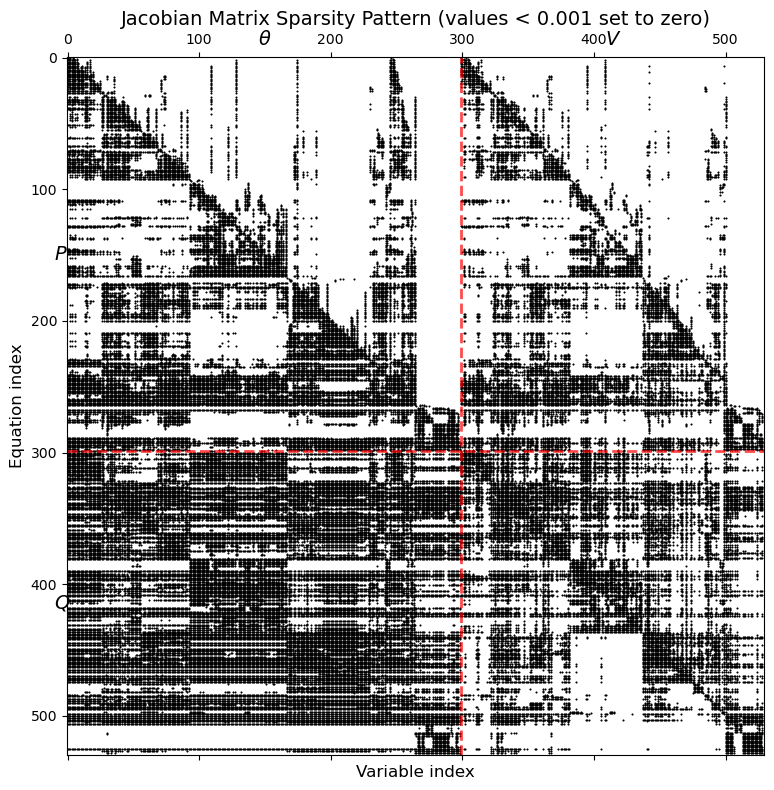

In [17]:
%matplotlib inline

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Plot the sparsity pattern
ax.spy(fjac_thresholded, markersize=0.5, color='black')

# Add partitioning lines to show the submatrices (P-θ, P-V, Q-θ, Q-V)
n_theta = len(loc.non_slack)
n_v = len(loc.non_gen)

ax.axhline(y=n_theta, color='r', linestyle='--', alpha=0.7, linewidth=2)
ax.axvline(x=n_theta, color='r', linestyle='--', alpha=0.7, linewidth=2)

# Add labels for the submatrices
ax.text(n_theta/2, -10, r'$\theta$', fontsize=14, ha='center')
ax.text(n_theta + n_v/2, -10, r'$V$', fontsize=14, ha='center')
ax.text(-10, n_theta/2, r'$P$', fontsize=14, va='center')
ax.text(-10, n_theta + n_v/2, r'$Q$', fontsize=14, va='center')

# Add titles and labels
ax.set_title(f'Jacobian Matrix Sparsity Pattern (values < {thres} set to zero)', fontsize=14)
ax.set_xlabel('Variable index', fontsize=12)
ax.set_ylabel('Equation index', fontsize=12)

plt.tight_layout()
plt.show()

We can clearly see the four blocks separated by the red lines. 

## Visualizing System Voltages

We use `networkx` to visualize power network topology and power flow results for intuition.

This visualization approach:

- Displays the network structure with buses (nodes) and transmission lines (edges)
- Encodes bus voltage magnitudes through color mapping (red for low, green for high voltage)
- Differentiates bus types using node sizes and colors (Slack, PV, PQ)
- Shows power flow directions with arrows
- Applies connected component sampling for large networks to maintain topological context
- Selectively labels critical buses (generators and slack buses) to reduce visual clutter

The visualization provides intuition into:
1. System connectivity and topology
2. Voltage profile across the network
3. Generator locations and their impact on voltage support
4. Power flow patterns and potential congestion areas

:::{admonition} Interactive Use
:class: note

For interactive exploration in Jupyter notebooks, consider using tools like `ipycytoscape` or `networkx` with `ipywidgets` to enable zooming, filtering, and displaying additional information on hover.

:::

In [18]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import time

def visualize_power_system(ss, ndata, max_buses=100, figsize=(12, 10),
                          sample_large_network=True, seed=42,
                          show_critical_labels=True, connected_sampling=True):
    """
    Power system visualization with connected sampling and selective labeling.

    Parameters:
    -----------
    ss : ANDES system object
    ndata : NodalData object with voltage magnitudes and angles
    max_buses : int, maximum number of buses to display (samples if larger)
    figsize : tuple, figure size
    sample_large_network : bool, whether to sample large networks
    seed : int, random seed for reproducibility
    show_critical_labels : bool, whether to show labels for important buses only
    connected_sampling : bool, whether to use connected component sampling
    """
    start_time = time.time()
    print("Creating network visualization...")

    # Create a new figure with axes
    fig, ax = plt.subplots(figsize=figsize)

    # First create a full graph to use for connected sampling
    full_graph = nx.Graph()

    # Add all buses as nodes
    for i in range(ss.Bus.n):
        if i in ss.Bus.idx2uid(ss.Slack.bus.v):
            bus_type = 'Slack'
        elif i in ss.Bus.idx2uid(ss.PV.bus.v):
            bus_type = 'PV'
        else:
            bus_type = 'PQ'

        full_graph.add_node(i, voltage=ndata.V[i], angle=ndata.theta[i], type=bus_type)

    # Add all lines as edges
    for idx, (from_bus, to_bus) in enumerate(zip(ss.Line.bus1.v, ss.Line.bus2.v)):
        from_idx = ss.Bus.idx2uid(from_bus)
        to_idx = ss.Bus.idx2uid(to_bus)
        full_graph.add_edge(from_idx, to_idx)

    # Determine if we need to sample the network
    if ss.Bus.n > max_buses and sample_large_network:
        print(f"Network too large ({ss.Bus.n} buses), sampling {max_buses} buses")

        if connected_sampling:
            # Start with slack buses and expand outward
            slack_buses = list(ss.Bus.idx2uid(ss.Slack.bus.v))
            if not slack_buses:  # If no slack bus, start with any bus
                slack_buses = [0]

            # Get a connected component starting from a slack bus
            try:
                # Use BFS to get connected buses
                bfs_edges = list(nx.bfs_edges(full_graph, source=slack_buses[0]))
                sampled_buses = {slack_buses[0]}

                # Add buses breadth-first until we have enough
                for u, v in bfs_edges:
                    sampled_buses.add(v)
                    if len(sampled_buses) >= max_buses:
                        break

                bus_indices = list(sampled_buses)
            except nx.NetworkXError:
                # Fallback to random sampling if BFS fails
                np.random.seed(seed)
                bus_indices = np.random.choice(np.arange(ss.Bus.n),
                                             size=min(max_buses, ss.Bus.n),
                                             replace=False)
        else:
            # Random sampling
            np.random.seed(seed)
            bus_indices = np.random.choice(np.arange(ss.Bus.n),
                                         size=min(max_buses, ss.Bus.n),
                                         replace=False)
    else:
        # Use all buses
        bus_indices = np.arange(ss.Bus.n)

    # Create display graph with only the sampled buses
    G = nx.Graph()

    # Add nodes (buses)
    for i in bus_indices:
        # Determine bus type
        if i in ss.Bus.idx2uid(ss.Slack.bus.v):
            bus_type = 'Slack'
        elif i in ss.Bus.idx2uid(ss.PV.bus.v):
            bus_type = 'PV'
        else:
            bus_type = 'PQ'

        G.add_node(i, voltage=ndata.V[i], angle=ndata.theta[i], type=bus_type)

    # Add edges (lines) - only those connected to sampled buses
    for idx, (from_bus, to_bus) in enumerate(zip(ss.Line.bus1.v, ss.Line.bus2.v)):
        from_idx = ss.Bus.idx2uid(from_bus)
        to_idx = ss.Bus.idx2uid(to_bus)

        # Only add edges where both buses are in our sampled set
        if from_idx in bus_indices and to_idx in bus_indices:
            # Use a simplified approach for power flow direction
            angle_diff = ndata.theta[from_idx] - ndata.theta[to_idx]
            flow_direction = 1 if angle_diff > 0 else -1

            G.add_edge(from_idx, to_idx, direction=flow_direction)

    print(f"Graph created with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    # Set node positions using a faster layout algorithm for large graphs
    if G.number_of_nodes() < 50:
        pos = nx.spring_layout(G, seed=seed)
    else:
        pos = nx.kamada_kawai_layout(G)

    print(f"Layout calculated in {time.time() - start_time:.2f} seconds")

    # Define node sizes and colors based on type
    node_sizes = []
    node_colors = []

    # Create labels dict - either critical buses only or all if small network
    labels = {}

    for n, data in G.nodes(data=True):
        # Size and color based on type
        if data['type'] == 'Slack':
            node_sizes.append(150)
            # Always label slack buses if showing critical labels
            if show_critical_labels:
                labels[n] = str(n)
        elif data['type'] == 'PV':
            node_sizes.append(100)
            # Label generator buses if showing critical labels
            if show_critical_labels:
                labels[n] = str(n)
        else:  # PQ buses
            node_sizes.append(50)

        # Color based on voltage (using RdYlGn colormap)
        v_normalized = (data['voltage'] - 0.9) / 0.2  # Range from 0.9 to 1.1
        v_normalized = np.clip(v_normalized, 0, 1)
        color = plt.cm.RdYlGn_r(v_normalized)
        node_colors.append(color)

    # If network is small and we're not doing critical-only labels, label all nodes
    if G.number_of_nodes() < 50 and not show_critical_labels:
        labels = {n: str(n) for n in G.nodes()}

    # Compute layout
    pos = nx.kamada_kawai_layout(G)  # or kamada_kawai_layout(G)

    # Separate nodes by type
    slack_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'Slack']
    pv_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'PV']
    pq_nodes = [n for n, d in G.nodes(data=True) if d['type'] == 'PQ']

    def get_node_colors(nodes):
        return [plt.cm.RdYlGn_r(np.clip((G.nodes[n]['voltage'] - 0.9) / 0.2, 0, 1)) for n in nodes]

    # Draw edges FIRST so nodes appear on top
    nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', arrows=False, width=1.0)

    # Draw Slack (squares)
    nx.draw_networkx_nodes(G, pos, nodelist=slack_nodes, node_color=get_node_colors(slack_nodes),
                           node_size=120, node_shape='s', ax=ax)

    # Draw PV (triangles)
    nx.draw_networkx_nodes(G, pos, nodelist=pv_nodes, node_color=get_node_colors(pv_nodes),
                           node_size=90, node_shape='^', ax=ax)

    # Draw PQ (circles)
    nx.draw_networkx_nodes(G, pos, nodelist=pq_nodes, node_color=get_node_colors(pq_nodes),
                           node_size=50, node_shape='o', ax=ax)

    # Draw labels last
    nx.draw_networkx_labels(G, pos, labels=labels, font_size=8, ax=ax)


    # Add legend
    slack_patch = plt.Line2D([0], [0], marker='s', color='w', markerfacecolor='gray',
                         markeredgecolor='black', markersize=10, linestyle='None', label='Slack Bus')

    pv_patch = plt.Line2D([0], [0], marker='^', color='w', markerfacecolor='gray',
                      markeredgecolor='black', markersize=9, linestyle='None', label='PV Bus')
    pq_patch = plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue',
                          markersize=6, label='PQ Bus')

    legend1 = ax.legend(handles=[slack_patch, pv_patch, pq_patch],
                    loc='upper right', title="Bus Types\n(marker shape)")

    # Add title and turn off axis
    ax.set_title(f"Power Network Visualization -- ({G.number_of_nodes()} buses)")
    ax.axis('off')

    # Create a separate colorbar for voltage levels
    sm = plt.cm.ScalarMappable(cmap='RdYlGn_r', norm=plt.Normalize(vmin=0.9, vmax=1.1))
    sm.set_array([])
    cbar_ax = fig.add_axes([0.92, 0.1, 0.02, 0.3])  # [left, bottom, width, height]
    cbar = fig.colorbar(sm, cax=cbar_ax)
    cbar.set_label('Voltage (p.u.)')

    print(f"Visualization completed in {time.time() - start_time:.2f} seconds")

    return fig, ax

Creating network visualization...
Graph created with 300 nodes and 409 edges
Layout calculated in 0.36 seconds
Visualization completed in 0.75 seconds


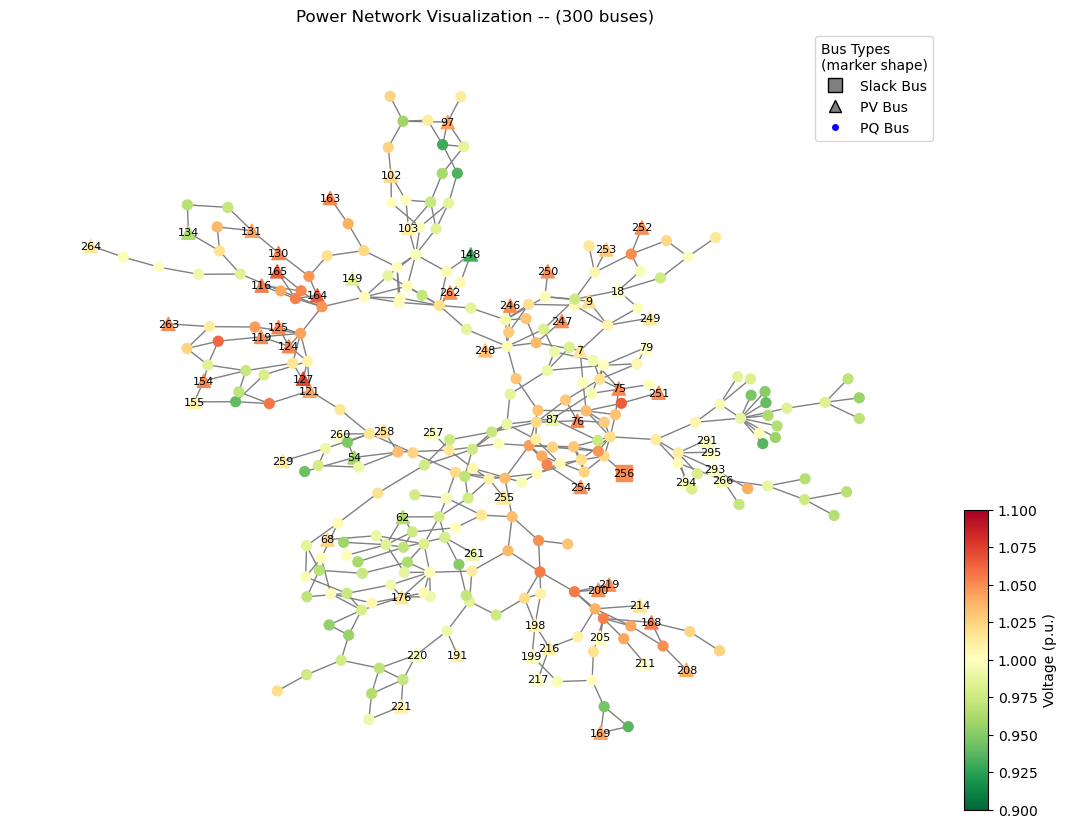

In [19]:
fig, ax = visualize_power_system(ss, ndata,
                                max_buses=999,
                                connected_sampling=True,
                                show_critical_labels=True)
plt.show()

## Quizzes

In [20]:
# Development for new questions
display_quiz(local_quiz, colors=color_dict)

<IPython.core.display.Javascript object>

In [21]:
display_quiz(git_quiz, colors=color_dict)

<IPython.core.display.Javascript object>

## References

```{bibliography}
:style: unsrt
:filter: docname in docnames
```